# NAEI Wales-UK Predictor - Machine Learning Practice by Rory Thomas
## Introduction
As you can see by the title, the whole point of this is for myself to practice some machine learning projects that aren't Kaggle-based or any other training website (I still love you though, I just can't keep using the same Titantic data set <3)

The whole purpose of this has been born out of trying to find something to do and came from a conversation between myself and Ash. Basically, the whole idea is that Wales' data always comes out later than the UK's and for many of the tasks within Decarb, we just use a scaled version of the UK's data to estimate what Wales' is.

The problem is that the scaled version isn't necessarily accurate, if you look at the data of the Wales inventory (from the NAEI) compared to the UK inventory, you can see a generally wavey graph with an average value of 0.074, and a standard deviation of 0.007. Not a bad standard deviation by any means but it is not entirely great.  
So this is a task to see if we can get something a bit more reasonable, and see what we can pull from this.

## Imports and Read-In
Let's pull in the imports we need for us to get going, and read in the CSVs

In [315]:
select_state = 42
# Chose this so we can reproduce our results

In [316]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [317]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [318]:
#from sklearn.linear_model import Ridge
#from sklearn.ensemble import RandomForestRegressor

We'll pull in the first data frame, which is the UK's data from 2022.

In [319]:
df_UK2022 = pd.read_csv("NAEI Data CleanUp - UK By Source 2022.csv",skiprows=15)
df_UK2022.drop(df_UK2022.columns[0],axis=1,inplace=True)
df_UK2022.head()

,TESS1,TESS2,IPCC_name,BaseYear,1990,1995,1998,1999,2000,2001,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Agriculture,Agricultural combustion,1A4ci_Agriculture/Forestry/Fishing:Stationary,592.807799,592.807799,725.383977,1047.959045,1394.343696,1265.118748,1590.000714,...,1203.368272,1131.455727,1122.611247,1356.081328,1335.889681,1292.264204,1292.816159,1251.390771,1104.237887,1221.885988
1,Agriculture,Agricultural combustion,1A4cii_Agriculture/Forestry/Fishing:Off-road,3442.949494,3442.949494,3480.022181,3606.220664,3836.247996,3781.690419,3625.295711,...,4198.897236,4404.868625,4933.560187,4584.441401,4500.144052,4773.969167,4433.520345,4754.534224,5228.866993,4734.120677
2,Agriculture,Agricultural combustion Total,NaN,4035.757293,4035.757293,4205.406157,4654.179709,5230.591691,5046.809167,5215.296426,...,5402.265508,5536.324352,6056.171433,5940.522729,5836.033734,6066.233370,5726.336504,6005.924996,6333.10488,5956.006665
3,Agriculture,Agricultural soils,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,5338.201072,5338.201072,5192.253377,4963.150742,5058.789218,4611.258712,4333.776094,...,3381.583007,3426.647575,3243.112361,3150.274289,3155.554398,3211.763562,3116.002202,2877.847239,2962.931136,2308.909146
4,Agriculture,Agricultural soils,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,1228.869565,1228.869565,1184.259363,1253.070364,1248.685408,1191.833019,1186.508607,...,1050.153739,1067.794061,1058.705552,1029.588057,1049.499691,1050.788593,1053.920472,1040.542818,1051.822685,1038.932448


We'll do the same for UK 2021, Wales 2021, and Wales 2022.

In [320]:
df_UK2021 = pd.read_csv("NAEI Data CleanUp - UK By Source 2021.csv",skiprows=15)
df_UK2021.drop(df_UK2021.columns[0],axis=1,inplace=True)
df_UK2021.head()

,NCFormat,IPCC_name,BaseYear,1990,1995,1998,1999,2000,2001,2002,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Agriculture,1A4ci_Agriculture/Forestry/Fishing:Stationary,590.388657,590.388657,722.459738,485.055755,573.903322,373.659868,524.484687,502.773255,...,270.802545,260.175779,265.937007,262.099290,265.354319,272.520550,272.400930,268.482555,272.951877,298.293550
1,NaN,1A4cii_Agriculture/Forestry/Fishing:Off-road,3442.910333,3442.910333,3479.983021,3606.181506,3836.208837,3781.651263,3625.256555,3983.809823,...,4978.863013,4150.948850,4359.067492,4889.354547,4541.913076,4812.575560,4783.037640,4274.081313,4104.564111,4850.624331
2,NaN,2D1_Lubricant_Use,11.313604,11.313604,13.696817,8.619302,8.655753,6.074182,5.732705,5.988012,...,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651
3,NaN,3A1a_Enteric_Fermentation_dairy_cattle,7824.314200,7824.314200,7345.230623,7133.725222,7252.776262,6954.094904,6861.805973,6857.045380,...,5923.243934,5954.231118,6299.540223,6423.300570,6307.300943,6389.660694,6361.129009,6424.907086,6413.510408,6442.859016
4,NaN,3A1b_Enteric_Fermentation_non-dairy_cattle,13341.705920,13341.705920,13561.875530,13699.417640,13540.554060,13318.011380,12682.226710,12371.272430,...,12486.362930,12264.926940,12303.842500,12349.875730,12421.461090,12267.794100,11997.440900,11823.486580,11650.501790,11642.738880


In [321]:
df_CY2021 = pd.read_csv("NAEI Data CleanUp - Wales By Source 2021.csv",skiprows=15)
df_CY2021.drop(df_CY2021.columns[0],axis=1,inplace=True)
df_CY2021.head()

,NCFormat,IPCC_name,BaseYear,1990,1995,1998,1999,2000,2001,2002,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Agriculture,1A4ci_Agriculture/Forestry/Fishing:Stationary,46.678209,46.678209,57.054046,39.271346,44.224179,38.627937,57.051499,55.496673,...,23.463871,21.450826,23.645293,22.735213,21.713342,21.224135,21.731359,22.368702,25.473576,28.261257
1,NaN,1A4cii_Agriculture/Forestry/Fishing:Off-road,419.351059,419.351059,423.866561,439.237705,467.255339,460.610154,441.561071,485.233336,...,607.605176,506.542568,530.327889,595.287408,551.696925,584.242939,582.076288,519.272135,500.975560,592.034665
2,NaN,2D1_Lubricant_Use,1.144694,1.144694,1.437742,0.887793,0.863379,0.677339,0.651687,0.687766,...,0.234941,0.217983,0.238325,0.235973,0.220805,0.213556,0.213949,0.215244,0.214039,0.205566
3,NaN,3A1a_Enteric_Fermentation_dairy_cattle,901.719928,901.719928,832.914166,812.415767,834.112474,803.336902,825.663241,828.330373,...,739.123987,752.784517,805.543924,840.327833,834.497997,854.910948,862.607781,868.083399,877.017158,891.350827
4,NaN,3A1b_Enteric_Fermentation_non-dairy_cattle,1493.532922,1493.532922,1540.525232,1587.726972,1594.136772,1550.707554,1541.698580,1435.707280,...,1373.219389,1341.664085,1349.773834,1351.805904,1358.072729,1343.889743,1324.171641,1315.314642,1307.925947,1314.475636


In [322]:
df_CY2022 = pd.read_csv("NAEI Data CleanUp - Wales By Source 2022.csv",skiprows=15)
df_CY2022.drop(df_CY2022.columns[0],axis=1,inplace=True)
df_CY2022.head()

,TESS1,TESS2,IPCC_name,BaseYear,1990,1995,1998,1999,2000,2001,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Agriculture,Agricultural combustion,1A4ci_Agriculture/Forestry/Fishing:Stationary,46.839858,46.839858,57.251552,62.386630,77.901227,75.219368,100.811915,...,59.274317,56.333023,63.913445,76.760896,70.905145,69.218893,74.798231,70.522510,63.514159,69.239418
1,Agriculture,Agricultural combustion,1A4cii_Agriculture/Forestry/Fishing:Off-road,419.355828,419.355828,423.871331,439.242474,467.260109,460.614924,441.565840,...,512.622992,536.234807,601.168270,557.119475,546.837681,581.342266,539.014987,580.241663,638.462495,578.052282
2,Agriculture,Agricultural combustion Total,NaN,466.195687,466.195687,481.122883,501.629104,545.161336,535.834291,542.377755,...,571.897309,592.567830,665.081714,633.880370,617.742826,650.561159,613.813218,650.764174,701.976653,647.291700
3,Agriculture,Agricultural soils,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,662.872491,662.872491,594.469564,561.123202,604.778248,504.552476,455.923192,...,346.009650,376.894083,330.958606,385.088890,404.630420,365.818406,368.928589,327.462867,351.408026,224.038163
4,Agriculture,Agricultural soils,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,96.869957,96.869957,94.060872,102.300612,105.215544,101.586269,104.324323,...,93.633089,97.582772,99.985033,98.415352,99.722773,101.220348,100.583876,102.158354,102.978105,102.621373


## Data Clean-Up
Let's make this data usable

Right so a few problems:
 - The 2021 data has relied on it's 'Excel-based' view such that we can imply that all of our NaN cells are actually within the NCFormat above what we see, so we need to clean that up.
 - The BaseYear column is useless to us, so let's drop that.
 - There are a few IPCC columns with blank values, so we'll go ahead and replace those with just 'Other'.
 - "Total" is included in the data, so we need to loop through and drop rows which are just the sum rows.
 - The 2022 data has TESS2 which is not relevant, we want to stick with the TESS1 (aka NCFormat) stuff.

Now let's bin the 'BaseYear' column

In [323]:
df_CY2021.drop("BaseYear",axis=1,inplace=True)
df_CY2022.drop("BaseYear",axis=1,inplace=True)
df_UK2021.drop("BaseYear",axis=1,inplace=True)
df_UK2022.drop("BaseYear",axis=1,inplace=True)
df_UK2022.head()

,TESS1,TESS2,IPCC_name,1990,1995,1998,1999,2000,2001,2002,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Agriculture,Agricultural combustion,1A4ci_Agriculture/Forestry/Fishing:Stationary,592.807799,725.383977,1047.959045,1394.343696,1265.118748,1590.000714,1379.486488,...,1203.368272,1131.455727,1122.611247,1356.081328,1335.889681,1292.264204,1292.816159,1251.390771,1104.237887,1221.885988
1,Agriculture,Agricultural combustion,1A4cii_Agriculture/Forestry/Fishing:Off-road,3442.949494,3480.022181,3606.220664,3836.247996,3781.690419,3625.295711,3983.848977,...,4198.897236,4404.868625,4933.560187,4584.441401,4500.144052,4773.969167,4433.520345,4754.534224,5228.866993,4734.120677
2,Agriculture,Agricultural combustion Total,NaN,4035.757293,4205.406157,4654.179709,5230.591691,5046.809167,5215.296426,5363.335465,...,5402.265508,5536.324352,6056.171433,5940.522729,5836.033734,6066.233370,5726.336504,6005.924996,6333.10488,5956.006665
3,Agriculture,Agricultural soils,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,5338.201072,5192.253377,4963.150742,5058.789218,4611.258712,4333.776094,4225.681290,...,3381.583007,3426.647575,3243.112361,3150.274289,3155.554398,3211.763562,3116.002202,2877.847239,2962.931136,2308.909146
4,Agriculture,Agricultural soils,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,1228.869565,1184.259363,1253.070364,1248.685408,1191.833019,1186.508607,1148.799176,...,1050.153739,1067.794061,1058.705552,1029.588057,1049.499691,1050.788593,1053.920472,1040.542818,1051.822685,1038.932448


We can tackle both the 'Totals' and the Empty NCFormats here.

In [324]:
for idx, row in enumerate(df_CY2021["NCFormat"]):
    if type(row)==str:
        last_header=row
        if "total" in row.lower():
            df_CY2021.drop(idx,axis=0,inplace=True)
    elif row is np.nan:
        df_CY2021.loc[idx, "NCFormat"] = last_header
df_CY2021.head()

,NCFormat,IPCC_name,1990,1995,1998,1999,2000,2001,2002,2003,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Agriculture,1A4ci_Agriculture/Forestry/Fishing:Stationary,46.678209,57.054046,39.271346,44.224179,38.627937,57.051499,55.496673,55.609147,...,23.463871,21.450826,23.645293,22.735213,21.713342,21.224135,21.731359,22.368702,25.473576,28.261257
1,Agriculture,1A4cii_Agriculture/Forestry/Fishing:Off-road,419.351059,423.866561,439.237705,467.255339,460.610154,441.561071,485.233336,491.181716,...,607.605176,506.542568,530.327889,595.287408,551.696925,584.242939,582.076288,519.272135,500.975560,592.034665
2,Agriculture,2D1_Lubricant_Use,1.144694,1.437742,0.887793,0.863379,0.677339,0.651687,0.687766,1.047121,...,0.234941,0.217983,0.238325,0.235973,0.220805,0.213556,0.213949,0.215244,0.214039,0.205566
3,Agriculture,3A1a_Enteric_Fermentation_dairy_cattle,901.719928,832.914166,812.415767,834.112474,803.336902,825.663241,828.330373,834.746441,...,739.123987,752.784517,805.543924,840.327833,834.497997,854.910948,862.607781,868.083399,877.017158,891.350827
4,Agriculture,3A1b_Enteric_Fermentation_non-dairy_cattle,1493.532922,1540.525232,1587.726972,1594.136772,1550.707554,1541.698580,1435.707280,1564.278541,...,1373.219389,1341.664085,1349.773834,1351.805904,1358.072729,1343.889743,1324.171641,1315.314642,1307.925947,1314.475636


In [325]:
for idx, row in enumerate(df_UK2021["NCFormat"]):
    if type(row)==str:
        last_header=row
        if "total" in row.lower():
            df_UK2021.drop(idx,axis=0,inplace=True)
    elif row is np.nan:
        df_UK2021.loc[idx, "NCFormat"] = last_header
df_UK2021.head()

,NCFormat,IPCC_name,1990,1995,1998,1999,2000,2001,2002,2003,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Agriculture,1A4ci_Agriculture/Forestry/Fishing:Stationary,590.388657,722.459738,485.055755,573.903322,373.659868,524.484687,502.773255,501.296833,...,270.802545,260.175779,265.937007,262.099290,265.354319,272.520550,272.400930,268.482555,272.951877,298.293550
1,Agriculture,1A4cii_Agriculture/Forestry/Fishing:Off-road,3442.910333,3479.983021,3606.181506,3836.208837,3781.651263,3625.256555,3983.809823,4032.646563,...,4978.863013,4150.948850,4359.067492,4889.354547,4541.913076,4812.575560,4783.037640,4274.081313,4104.564111,4850.624331
2,Agriculture,2D1_Lubricant_Use,11.313604,13.696817,8.619302,8.655753,6.074182,5.732705,5.988012,8.895657,...,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651
3,Agriculture,3A1a_Enteric_Fermentation_dairy_cattle,7824.314200,7345.230623,7133.725222,7252.776262,6954.094904,6861.805973,6857.045380,6794.505180,...,5923.243934,5954.231118,6299.540223,6423.300570,6307.300943,6389.660694,6361.129009,6424.907086,6413.510408,6442.859016
4,Agriculture,3A1b_Enteric_Fermentation_non-dairy_cattle,13341.705920,13561.875530,13699.417640,13540.554060,13318.011380,12682.226710,12371.272430,12759.764330,...,12486.362930,12264.926940,12303.842500,12349.875730,12421.461090,12267.794100,11997.440900,11823.486580,11650.501790,11642.738880


For the 2022 data, we don't have to worry about the NCFormat

In [326]:
for idx, row in df_UK2022.iterrows():
    if type(row[0])==str and "total" in row[0].lower():
        df_UK2022.drop(idx,axis=0,inplace=True)
    elif type(row[1])==str and "total" in row[1].lower():
        df_UK2022.drop(idx,axis=0,inplace=True)
df_UK2022.head(60)

,TESS1,TESS2,IPCC_name,1990,1995,1998,1999,2000,2001,2002,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Agriculture,Agricultural combustion,1A4ci_Agriculture/Forestry/Fishing:Stationary,592.807799,725.383977,1047.959045,1394.343696,1265.118748,1590.000714,1379.486488,...,1203.368272,1131.455727,1122.611247,1356.081328,1335.889681,1292.264204,1292.816159,1251.390771,1104.237887,1221.885988
1,Agriculture,Agricultural combustion,1A4cii_Agriculture/Forestry/Fishing:Off-road,3442.949494,3480.022181,3606.220664,3836.247996,3781.690419,3625.295711,3983.848977,...,4198.897236,4404.868625,4933.560187,4584.441401,4500.144052,4773.969167,4433.520345,4754.534224,5228.866993,4734.120677
3,Agriculture,Agricultural soils,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,5338.201072,5192.253377,4963.150742,5058.789218,4611.258712,4333.776094,4225.681290,...,3381.583007,3426.647575,3243.112361,3150.274289,3155.554398,3211.763562,3116.002202,2877.847239,2962.931136,2308.909146
4,Agriculture,Agricultural soils,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,1228.869565,1184.259363,1253.070364,1248.685408,1191.833019,1186.508607,1148.799176,...,1050.153739,1067.794061,1058.705552,1029.588057,1049.499691,1050.788593,1053.920472,1040.542818,1051.822685,1038.932448
5,Agriculture,Agricultural soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied...,78.249509,84.241843,77.770543,84.350775,90.931007,128.059831,138.190764,...,198.286042,205.241234,219.139388,220.916523,227.913377,238.571704,239.686714,239.687073,239.6870726,239.687073
6,Agriculture,Agricultural soils,3D12c_Agricultural_Soils_Other_Organic_Fertili...,NaN,0.203816,0.212594,0.213128,0.208812,0.214409,1.816305,...,86.821891,134.031384,174.951405,235.491302,262.621027,271.295408,273.549612,278.159195,285.3481676,288.572157
7,Agriculture,Agricultural soils,3D13_Agricultural_Soils_Manure_Deposited_by_Gr...,781.959148,775.885334,804.263748,800.703913,774.781332,723.749789,708.739998,...,624.732919,649.565388,650.444439,644.778016,649.327510,630.397401,638.667093,627.842379,632.6757822,629.009481
8,Agriculture,Agricultural soils,3D14_Agriculural_Soils_Residues,1193.098585,1178.090386,1286.713025,1305.751361,1261.744572,1132.130354,1305.206107,...,1325.345926,1513.178503,1546.128123,1349.782220,1468.689628,1342.194853,1472.711909,1183.585698,1277.99177,1367.595837
9,Agriculture,Agricultural soils,3D15_Agricultural_soils_Mineralization/Immobil...,161.957994,206.924491,242.088231,254.690096,266.719313,276.886435,288.026513,...,348.340936,349.166467,350.001251,350.025012,349.664786,347.779395,345.941389,345.495156,344.3150379,338.721431
10,Agriculture,Agricultural soils,3D16_Agricultural_soils_Cultivation_of_Organic...,1938.184074,1918.469850,1906.624085,1902.712212,1897.235885,1892.912152,1888.708233,...,1851.659783,1849.175208,1846.668074,1844.183499,1841.698925,1839.214350,1836.626188,1834.141614,1831.657039,1829.172464


In [327]:
for idx, row in df_CY2022.iterrows():
    if type(row[0])==str and "total" in row[0].lower():
        df_CY2022.drop(idx,axis=0,inplace=True)
    elif type(row[1])==str and "total" in row[1].lower():
        df_CY2022.drop(idx,axis=0,inplace=True)
        
df_CY2022.head(60)

,TESS1,TESS2,IPCC_name,1990,1995,1998,1999,2000,2001,2002,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Agriculture,Agricultural combustion,1A4ci_Agriculture/Forestry/Fishing:Stationary,46.839858,57.251552,62.386630,77.901227,75.219368,100.811915,91.522700,...,59.274317,56.333023,63.913445,76.760896,70.905145,69.218893,74.798231,70.522510,63.514159,69.239418
1,Agriculture,Agricultural combustion,1A4cii_Agriculture/Forestry/Fishing:Off-road,419.355828,423.871331,439.242474,467.260109,460.614924,441.565840,485.238105,...,512.622992,536.234807,601.168270,557.119475,546.837681,581.342266,539.014987,580.241663,638.462495,578.052282
3,Agriculture,Agricultural soils,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,662.872491,594.469564,561.123202,604.778248,504.552476,455.923192,407.651649,...,346.009650,376.894083,330.958606,385.088890,404.630420,365.818406,368.928589,327.462867,351.408026,224.038163
4,Agriculture,Agricultural soils,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,96.869957,94.060872,102.300612,105.215544,101.586269,104.324323,91.867990,...,93.633089,97.582772,99.985033,98.415352,99.722773,101.220348,100.583876,102.158354,102.978105,102.621373
5,Agriculture,Agricultural soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied...,2.509002,2.920794,2.215796,3.242669,3.494092,3.709602,4.029389,...,12.081501,12.505279,13.352089,13.460369,13.886685,14.536093,14.604052,14.604052,14.604052,14.604052
6,Agriculture,Agricultural soils,3D12c_Agricultural_Soils_Other_Organic_Fertili...,NaN,0.126551,0.135441,0.136338,0.131768,0.136800,0.127938,...,1.970442,4.633846,6.594504,11.022151,11.650260,11.694540,11.562213,12.129140,12.119695,12.140324
7,Agriculture,Agricultural soils,3D13_Agricultural_Soils_Manure_Deposited_by_Gr...,112.520870,115.697487,119.333337,120.920664,115.506739,110.435846,109.071135,...,95.662392,101.610987,100.469736,100.277249,102.232937,97.873812,100.508990,96.995046,100.943422,99.713856
8,Agriculture,Agricultural soils,3D14_Agriculural_Soils_Residues,26.784519,27.009773,29.130961,28.981883,27.933998,27.811089,28.345941,...,37.981943,40.547636,42.942275,41.934639,42.766109,43.399579,45.802005,39.058777,44.567906,46.742099
9,Agriculture,Agricultural soils,3D15_Agricultural_soils_Mineralization/Immobil...,5.817405,8.469557,11.386937,12.217857,13.218572,13.888693,14.808019,...,17.589431,17.338492,17.054766,17.035765,16.825184,16.519154,16.063158,15.668951,15.346674,15.038838
10,Agriculture,Agricultural soils,3D16_Agricultural_soils_Cultivation_of_Organic...,20.887119,20.566149,20.433099,20.405139,20.383874,20.377804,20.355386,...,20.343289,20.343052,20.342816,20.342579,20.342342,20.342105,20.341869,20.341632,20.341395,20.341158


Let's drop "TESS2" and rename "NCFormat" to "TESS1"

In [328]:
df_CY2021.rename(columns={"NCFormat": "TESS1","IPCC_name": "CY2021"},inplace=True)
df_CY2022.drop("TESS2",axis=1,inplace=True)
df_CY2022.rename(columns={"IPCC_name":"CY2022"},inplace=True)

df_UK2021.rename(columns={"NCFormat": "TESS1","IPCC_name":"UK2021"},inplace=True)
df_UK2022.drop("TESS2",axis=1,inplace=True)
df_UK2022.rename(columns={"IPCC_name":"UK2022"},inplace=True)
df_UK2021.head()

,TESS1,UK2021,1990,1995,1998,1999,2000,2001,2002,2003,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Agriculture,1A4ci_Agriculture/Forestry/Fishing:Stationary,590.388657,722.459738,485.055755,573.903322,373.659868,524.484687,502.773255,501.296833,...,270.802545,260.175779,265.937007,262.099290,265.354319,272.520550,272.400930,268.482555,272.951877,298.293550
1,Agriculture,1A4cii_Agriculture/Forestry/Fishing:Off-road,3442.910333,3479.983021,3606.181506,3836.208837,3781.651263,3625.256555,3983.809823,4032.646563,...,4978.863013,4150.948850,4359.067492,4889.354547,4541.913076,4812.575560,4783.037640,4274.081313,4104.564111,4850.624331
2,Agriculture,2D1_Lubricant_Use,11.313604,13.696817,8.619302,8.655753,6.074182,5.732705,5.988012,8.895657,...,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651,1.902651
3,Agriculture,3A1a_Enteric_Fermentation_dairy_cattle,7824.314200,7345.230623,7133.725222,7252.776262,6954.094904,6861.805973,6857.045380,6794.505180,...,5923.243934,5954.231118,6299.540223,6423.300570,6307.300943,6389.660694,6361.129009,6424.907086,6413.510408,6442.859016
4,Agriculture,3A1b_Enteric_Fermentation_non-dairy_cattle,13341.705920,13561.875530,13699.417640,13540.554060,13318.011380,12682.226710,12371.272430,12759.764330,...,12486.362930,12264.926940,12303.842500,12349.875730,12421.461090,12267.794100,11997.440900,11823.486580,11650.501790,11642.738880


In [329]:
df_CY2021 = df_CY2021.set_index('TESS1').T
df_CY2022 = df_CY2022.set_index('TESS1').T
df_UK2021 = df_UK2021.set_index('TESS1').T
df_UK2022 = df_UK2022.set_index('TESS1').T

In [330]:
df_CY2021_sector = df_CY2021.columns
df_CY2022_sector = df_CY2022.columns
df_UK2021_sector = df_UK2021.columns
df_UK2022_sector = df_UK2022.columns

In [331]:
df_CY2021.columns = df_CY2021.iloc[0]
df_CY2021.drop("CY2021",axis=0,inplace=True)
df_CY2021 = df_CY2021.iloc[:,:-1]
df_CY2021.reset_index(inplace=True)
df_CY2021.rename(columns={"index": "Year"}, inplace=True)

df_CY2022.columns = df_CY2022.iloc[0]
df_CY2022.drop("CY2022",axis=0,inplace=True)
df_CY2022 = df_CY2022.iloc[:,:-1]
df_CY2022.reset_index(inplace=True)
df_CY2022.reset_index(inplace=True)
df_CY2022.rename(columns={"index": "Year"}, inplace=True)

df_UK2021.columns = df_UK2021.iloc[0]
df_UK2021.drop("UK2021",axis=0,inplace=True)
df_UK2021 = df_UK2021.iloc[:,:-1]
df_UK2021.reset_index(inplace=True)
df_UK2021.rename(columns={"index": "Year"}, inplace=True)

df_UK2022.columns = df_UK2022.iloc[0]
df_UK2022.drop("UK2022",axis=0,inplace=True)
df_UK2022 = df_UK2022.iloc[:,:-1]
df_UK2022.reset_index(inplace=True)
df_UK2022.rename(columns={"index": "Year"}, inplace=True)

In [332]:
df_UK2022_sector
df_UK2022

Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

UK2022,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied_to_Soils,3D12c_Agricultural_Soils_Other_Organic_Fertilisers_Applied_to_Soils,3D13_Agricultural_Soils_Manure_Deposited_by_Grazing_Animals,3D14_Agriculural_Soils_Residues,3D15_Agricultural_soils_Mineralization/Immobilization,...,5B2a_Anaerobic_digestion_municipal_solid_waste,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5C2.2b_Non-biogenic:Other,5C2.2b_Non-biogenic:Other_Accidental fires (vehicles),5D1_Domestic_wastewater_treatment,5D2_Industrial_wastewater_treatment,5C2.1b_Biogenic:Other
0,1990,592.808,3442.95,5338.2,1228.87,78.2495,NaN,781.959,1193.1,161.958,...,0.119923,20.4952,735.479,311.029,447.08,26.4565,1.7927,2198.21,938.167,169.894
1,1995,725.384,3480.02,5192.25,1184.26,84.2418,0.203816,775.885,1178.09,206.924,...,0.20408,22.4081,433.841,239.937,445.025,25.5531,2.0118,2208.29,969.049,157.921
2,1998,1047.96,3606.22,4963.15,1253.07,77.7705,0.212594,804.264,1286.71,242.088,...,0.218106,50.5549,0,209.723,441.464,19.3471,1.9537,2267.05,958.87,158.789
3,1999,1394.34,3836.25,5058.79,1248.69,84.3508,0.213128,800.704,1305.75,254.69,...,0.218106,51.7653,0,215.055,387.315,21.5493,2.3016,2144.03,959.982,155.467
4,2000,1265.12,3781.69,4611.26,1191.83,90.931,0.208812,774.781,1261.74,266.719,...,0.218106,52.9757,0,220.387,406.258,19.37,2.2344,2055.93,884.558,154.238
5,2001,1590,3625.3,4333.78,1186.51,128.06,0.214409,723.75,1132.13,276.886,...,0.598243,54.1861,0,225.718,345.836,20.6665,2.3912,1553.8,828.053,154.72
6,2002,1379.49,3983.85,4225.68,1148.8,138.191,1.8163,708.74,1305.21,288.027,...,1.6904,55.3965,0,231.05,325.886,20.5238,2.27255,1541.66,887.461,155.702
7,2003,1375.61,4032.69,4148.91,1148.19,163.294,1.81477,708.565,1303.73,298.01,...,1.66047,56.6069,0,196.529,342.995,22.8037,2.21585,1582.9,917.296,145.931
8,2004,1515.7,4341.88,3870.14,1174.38,172.35,2.85131,710.852,1269.72,305.872,...,2.87542,57.8172,0,162.007,359.165,18.7529,1.89096,1617.29,910.444,144.254
9,2005,1528.65,4500.94,3625.59,1146.43,187.418,5.64928,714.151,1298.97,314.983,...,4.77948,59.0276,0,127.485,340.056,18.0847,1.74724,1684.76,945.259,143.624


In [333]:
df_CY2021 = df_CY2021.astype(float)
df_CY2022 = df_CY2022.astype(float)
df_UK2021 = df_UK2021.astype(float)
df_UK2022 = df_UK2022.astype(float)

## Plot some stuff
Let's have a look at what's going on

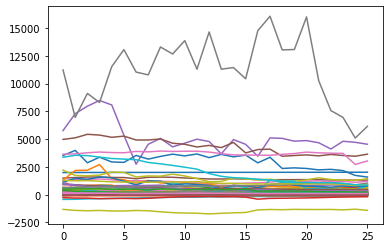

In [334]:
df_CY2021.plot(legend=False)
plt.show()

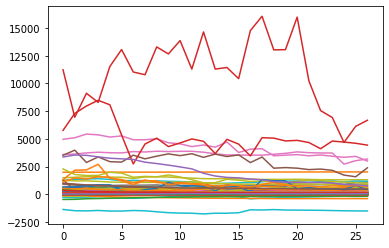

In [335]:
df_CY2022.plot(legend=False)
plt.show()

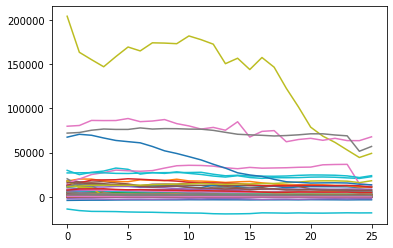

In [336]:
df_UK2021.plot(legend=False)
plt.show()

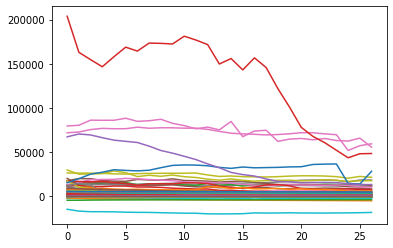

In [337]:
df_UK2022.plot(legend=False)
plt.show()

In [338]:
df_UK2022["Total"] = df_UK2022.sum(axis=1)
df_UK2021["Total"] = df_UK2021.sum(axis=1)
df_CY2022["Total"] = df_CY2022.sum(axis=1)
df_CY2021["Total"] = df_CY2021.sum(axis=1)
df_UK2022.tail()


Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

UK2022,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied_to_Soils,3D12c_Agricultural_Soils_Other_Organic_Fertilisers_Applied_to_Soils,3D13_Agricultural_Soils_Manure_Deposited_by_Grazing_Animals,3D14_Agriculural_Soils_Residues,3D15_Agricultural_soils_Mineralization/Immobilization,...,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5C2.2b_Non-biogenic:Other,5C2.2b_Non-biogenic:Other_Accidental fires (vehicles),5D1_Domestic_wastewater_treatment,5D2_Industrial_wastewater_treatment,5C2.1b_Biogenic:Other,Total
22,2018.0,1292.264204,4773.969167,3211.763562,1050.788593,238.571704,271.295408,630.397401,1342.194853,347.779395,...,30.489007,0.0,81.456840,158.085084,6.787779,0.804531,1519.340811,1348.937922,132.918272,508819.025781
23,2019.0,1292.816159,4433.520345,3116.002202,1053.920472,239.686714,273.549612,638.667093,1472.711909,345.941389,...,24.008409,0.0,85.012357,151.586492,6.463726,0.746746,1520.399819,1279.960280,133.325645,493973.325191
24,2020.0,1251.390771,4754.534224,2877.847239,1040.542818,239.687073,278.159195,627.842379,1183.585698,345.495156,...,19.421299,0.0,82.147602,160.917891,5.979380,0.678189,1533.005165,1163.328872,130.342158,426913.028621
25,2021.0,1104.237887,5228.866993,2962.931136,1051.822685,239.687073,285.348168,632.675782,1277.991770,344.315038,...,19.299420,0.0,71.116041,196.650735,5.894549,0.724143,1531.017344,1303.659801,131.200257,443315.716575
26,2022.0,1221.885988,4734.120677,2308.909146,1038.932448,239.687073,288.572157,629.009481,1367.595837,338.721431,...,22.105084,0.0,71.405548,213.414242,6.234931,0.770389,1535.139672,1371.126181,131.492887,442961.991067


Let's whack a total column in for each year, see what's happening.

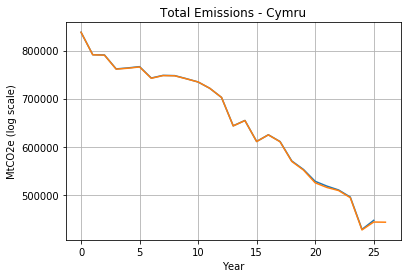

In [339]:
df_UK2021["Total"].plot()
df_UK2022["Total"].plot()
plt.title("Total Emissions - Cymru")
plt.xlabel("Year")
plt.ylabel("MtCO2e (log scale)")
plt.grid()
plt.show()

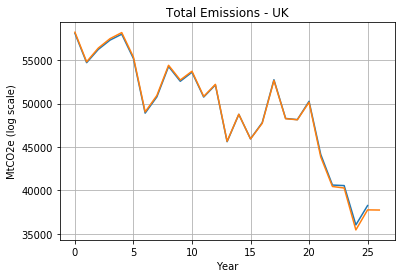

In [340]:
df_CY2021["Total"].plot()
df_CY2022["Total"].plot()
plt.title("Total Emissions - UK")
plt.xlabel("Year")
plt.ylabel("MtCO2e (log scale)")
plt.grid()
plt.show()

## Some Last Checks
Check all is well before we move on

In [341]:
df_CY2022.describe()

Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

CY2022,level_0,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied_to_Soils,3D12c_Agricultural_Soils_Other_Organic_Fertilisers_Applied_to_Soils,3D13_Agricultural_Soils_Manure_Deposited_by_Grazing_Animals,3D14_Agriculural_Soils_Residues,...,5B2a_Anaerobic_digestion_municipal_solid_waste,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5C2.2b_Non-biogenic:Other,5C2.2b_Non-biogenic:Other_Accidental fires (vehicles),5D1_Domestic_wastewater_treatment,5D2_Industrial_wastewater_treatment,Total
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,26.000000,27.000000,27.000000,...,27.000000,27.000000,27.0,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,13.000000,2008.703704,73.009795,534.842338,408.929753,97.544956,8.568389,3.848723,103.873286,35.041377,...,3.354086,2.212734,0.0,6.605385,11.093397,0.665159,0.067046,109.029151,50.498624,49145.209490
std,7.937254,8.502555,13.341576,65.598913,100.452165,4.958766,4.648868,5.122403,8.336059,6.725469,...,4.072127,0.751433,0.0,3.454222,14.984854,0.351258,0.030716,10.904723,8.848311,6514.424898
min,0.000000,1990.000000,46.839858,419.355828,224.038163,88.645465,2.215796,0.111670,92.443562,26.784519,...,0.005995,0.894163,0.0,3.294882,0.081822,0.273101,0.032048,97.185863,33.458631,35439.122847
25%,6.500000,2002.500000,63.712502,488.212295,347.372941,92.871159,3.869495,0.126897,97.434429,29.004182,...,0.082511,1.578566,0.0,3.969764,0.128625,0.331746,0.038150,98.646876,45.749385,45787.036880
50%,13.000000,2009.000000,70.905145,545.583195,376.894083,98.239551,7.334027,0.375095,101.610987,35.183643,...,0.819247,2.564140,0.0,4.854339,4.377717,0.573115,0.057847,104.435596,50.196658,50144.660792
75%,19.500000,2015.500000,80.577760,579.146973,437.412881,101.872312,13.406229,9.915239,110.543953,41.241138,...,7.959501,2.773584,0.0,10.040083,12.128599,0.957765,0.095079,117.523548,53.901047,54063.760968
max,26.000000,2022.000000,100.811915,659.115002,662.872491,105.215544,14.604052,12.140324,120.920664,46.742099,...,10.393557,3.065522,0.0,15.549431,50.047744,1.322652,0.117722,129.674356,70.404061,58212.140946


In [342]:
df_CY2021.describe()

Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

CY2021,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,2D1_Lubricant_Use,3A1a_Enteric_Fermentation_dairy_cattle,3A1b_Enteric_Fermentation_non-dairy_cattle,3A2_Enteric_Fermentation_sheep,3A3_Enteric_Fermentation_swine,3A4_Enteric_Fermentation_other:deer,3A4_Enteric_Fermentation_other:goats,...,2D3_Non-energy_products_from_fuels_and_solvent_use:Other,5A1a_Managed_Waste_Disposal_sites_anaerobic,5B1a_composting_municipal_solid_waste,5B2a_Anaerobic_digestion_municipal_solid_waste,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5D1_Domestic_wastewater_treatment,Total
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,...,16.000000,26.000000,26.000000,26.000000,26.000000,26.0,26.000000,26.000000,26.000000,26.000000
mean,2008.192308,36.326697,527.295227,0.490814,811.384189,1440.363518,1189.041954,1.663342,0.562509,2.244545,...,0.943039,2076.537800,45.807019,3.090731,2.259121,0.0,6.734682,11.514998,109.500034,49597.198884
std,8.236598,13.497884,63.308468,0.362437,53.081039,99.672123,112.719563,1.046197,0.131830,0.620731,...,0.439000,977.173057,25.480538,3.910413,0.725699,0.0,3.455394,15.117426,10.860887,6043.214284
min,1990.000000,21.224135,419.351059,0.205566,724.848123,1307.925947,982.317283,0.873936,0.389200,1.384236,...,0.041604,855.715618,0.000000,0.005995,0.911897,0.0,3.360207,0.081822,97.186690,36016.836087
25%,2002.250000,23.509227,486.720431,0.224330,761.363132,1350.281851,1127.586556,1.033567,0.498400,1.735020,...,0.642030,1104.395843,24.789615,0.082153,1.766209,0.0,4.086390,1.000202,98.575930,46397.093565
50%,2008.500000,31.931563,529.585380,0.300107,826.996807,1422.001160,1196.749962,1.166424,0.529760,2.034396,...,1.156081,1775.147242,40.926034,0.588899,2.589628,0.0,4.895807,4.539409,107.141478,50500.833230
75%,2014.750000,46.711447,578.006828,0.685159,851.265169,1541.405243,1239.161042,1.821950,0.566440,2.912112,...,1.297246,3084.301416,71.535991,6.824694,2.781024,0.0,10.219636,12.349102,118.454542,54100.966250
max,2021.000000,57.054046,657.016788,1.437742,901.719928,1594.136772,1413.772167,4.238304,0.993440,3.281544,...,1.346585,3547.384702,81.463988,9.955900,3.065495,0.0,15.549431,50.047744,129.674865,58088.321146


In [343]:
df_UK2022.describe()

Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

UK2022,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied_to_Soils,3D12c_Agricultural_Soils_Other_Organic_Fertilisers_Applied_to_Soils,3D13_Agricultural_Soils_Manure_Deposited_by_Grazing_Animals,3D14_Agriculural_Soils_Residues,3D15_Agricultural_soils_Mineralization/Immobilization,...,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5C2.2b_Non-biogenic:Other,5C2.2b_Non-biogenic:Other_Accidental fires (vehicles),5D1_Domestic_wastewater_treatment,5D2_Industrial_wastewater_treatment,5C2.1b_Biogenic:Other,Total
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,26.000000,27.000000,27.000000,27.000000,...,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,2008.703704,1263.346757,4386.280195,3670.474628,1110.905544,180.598800,94.709045,684.344047,1323.609308,312.584970,...,45.511387,43.308121,135.219533,259.685313,13.598241,1.373080,1703.281251,1138.208966,140.933618,646963.896798
std,8.502555,221.125401,533.861591,787.827425,70.319580,55.166585,117.327586,58.824696,101.371373,49.111656,...,15.094428,161.543697,68.252822,104.459483,6.964773,0.607744,244.615224,182.776944,11.745030,123705.565689
min,1990.000000,592.807799,3442.949494,2308.909146,1029.588057,77.770543,0.203816,624.732919,1132.130354,161.957994,...,19.299420,0.000000,71.116041,151.586492,5.894549,0.678189,1513.494071,828.052944,128.880163,426913.028621
25%,2002.500000,1199.414451,4008.267349,3156.182809,1051.305639,150.742230,2.075056,638.602072,1273.130570,293.018079,...,33.383210,0.000000,83.908797,169.988490,6.982993,0.805160,1532.011255,952.064188,131.312528,538178.324996
50%,2009.000000,1292.816159,4466.930479,3347.154640,1077.965778,198.286042,17.598311,650.444439,1305.751361,337.793994,...,52.389412,0.000000,99.013310,213.414242,11.741883,1.185156,1582.903240,1169.405404,137.865408,654355.162090
75%,2015.500000,1377.547277,4744.327450,4187.298094,1161.589187,220.027956,220.356327,712.501555,1367.697149,346.137536,...,56.888016,0.000000,203.125671,344.415850,19.358548,1.922330,1748.019283,1281.852502,150.084402,747726.747034
max,2022.000000,1590.000714,5386.093332,5338.201072,1253.070364,239.687073,288.572157,804.263748,1546.128123,350.025012,...,63.078898,735.478680,311.029382,447.080047,26.456503,2.391200,2267.048812,1379.763605,169.893594,838057.230037


In [344]:
df_UK2021.describe()

Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

UK2021,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,2D1_Lubricant_Use,3A1a_Enteric_Fermentation_dairy_cattle,3A1b_Enteric_Fermentation_non-dairy_cattle,3A2_Enteric_Fermentation_sheep,3A3_Enteric_Fermentation_swine,3A4_Enteric_Fermentation_other:deer,3A4_Enteric_Fermentation_other:goats,...,2D3_Non-energy_products_from_fuels_and_solvent_use:Other,5A1a_Managed_Waste_Disposal_sites_anaerobic,5B1a_composting_municipal_solid_waste,5B2a_Anaerobic_digestion_municipal_solid_waste,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5D1_Domestic_wastewater_treatment,Total
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,...,16.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,2008.192308,391.510713,4327.434678,4.386318,6529.942247,12689.089065,4953.658244,227.659503,19.217936,23.996152,...,42.477275,38262.667742,952.838716,65.053664,46.411630,44.973818,137.673898,261.464970,1710.149804,655583.292574
std,8.236598,132.684942,518.443441,3.487863,479.559891,590.853829,536.690504,44.862107,2.450128,2.758206,...,20.669125,21149.729605,543.310635,82.687305,14.635517,164.506266,68.378611,106.109945,246.803429,118439.849572
min,1990.000000,260.175779,3442.910333,1.902651,5923.243934,11642.738880,4257.330488,186.506502,17.112449,18.711727,...,1.896320,13618.050960,0.000000,0.119923,19.299420,0.000000,71.115544,151.586492,1513.493273,428035.880345
25%,2002.250000,272.430835,3996.019008,1.902651,6288.954342,12315.350808,4657.616495,202.445932,17.485377,23.158044,...,27.277053,16591.716047,503.426397,1.667954,37.301833,0.000000,86.155514,169.509955,1535.077686,557080.331027
50%,2008.500000,333.771452,4350.457785,2.501426,6403.131873,12640.742945,4750.933348,209.598793,18.415040,24.400661,...,51.598103,34656.734605,836.752786,12.055286,52.682562,0.000000,100.303974,207.382420,1600.102997,678534.568649
75%,2014.750000,500.917363,4746.222096,6.052639,6841.410330,13144.837202,5059.103125,231.913238,20.160000,25.337403,...,60.194684,60001.257868,1500.820211,143.210256,57.028597,0.000000,206.424170,345.126162,1748.126812,748243.190492
max,2021.000000,722.459738,5386.061829,13.696817,7824.314200,13699.417640,6080.694216,342.150900,26.496323,28.319007,...,61.757809,70663.134170,1724.106827,210.707032,63.078898,735.478680,311.029382,447.080047,2267.052262,838101.314785


In [345]:
print(f'Number of rows with missing values in 2021 Cymru Data: {df_CY2021.isnull().any(axis=1).mean()}')
print(f'Number of rows with missing values in 2021 Cymru Data: {df_CY2022.isnull().any(axis=1).mean()}')
print(f'Number of rows with missing values in 2021 Cymru Data: {df_UK2021.isnull().any(axis=1).mean()}')
print(f'Number of rows with missing values in 2021 Cymru Data: {df_UK2022.isnull().any(axis=1).mean()}')

Number of rows with missing values in 2021 Cymru Data: 1.0
Number of rows with missing values in 2021 Cymru Data: 1.0
Number of rows with missing values in 2021 Cymru Data: 1.0
Number of rows with missing values in 2021 Cymru Data: 1.0


Finally, let's look at some dead columns, ones with null data.
I kind of don't want to work with this so I am going to just drop the Null rows.
### TODO: Find solution to Null Rows

In [346]:
UK2022_naCols = df_UK2022.columns[df_UK2022.isnull().any()]
df_UK2022.dropna(axis=1,inplace=True)
df_UK2022.head()


Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

UK2022,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied_to_Soils,3D13_Agricultural_Soils_Manure_Deposited_by_Grazing_Animals,3D14_Agriculural_Soils_Residues,3D15_Agricultural_soils_Mineralization/Immobilization,3D16_Agricultural_soils_Cultivation_of_Organic_Soils,...,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5C2.2b_Non-biogenic:Other,5C2.2b_Non-biogenic:Other_Accidental fires (vehicles),5D1_Domestic_wastewater_treatment,5D2_Industrial_wastewater_treatment,5C2.1b_Biogenic:Other,Total
0,1990.0,592.807799,3442.949494,5338.201072,1228.869565,78.249509,781.959148,1193.098585,161.957994,1938.184074,...,20.495250,735.478680,311.029382,447.080047,26.456503,1.7927,2198.207857,938.166845,169.893594,838057.230037
1,1995.0,725.383977,3480.022181,5192.253377,1184.259363,84.241843,775.885334,1178.090386,206.924491,1918.469850,...,22.408140,433.840582,239.936952,445.024507,25.553091,2.0118,2208.287183,969.048764,157.920611,791177.841629
2,1998.0,1047.959045,3606.220664,4963.150742,1253.070364,77.770543,804.263748,1286.713025,242.088231,1906.624085,...,50.554950,0.000000,209.722669,441.464222,19.347091,1.9537,2267.048812,958.869742,158.788653,790439.204026
3,1999.0,1394.343696,3836.247996,5058.789218,1248.685408,84.350775,800.703913,1305.751361,254.690096,1902.712212,...,51.765331,0.000000,215.054601,387.315361,21.549346,2.3016,2144.031434,959.981603,155.467134,761349.748479
4,2000.0,1265.118748,3781.690419,4611.258712,1191.833019,90.931007,774.781332,1261.744572,266.719313,1897.235885,...,52.975712,0.000000,220.386533,406.257950,19.370005,2.2344,2055.929624,884.558215,154.238280,763265.641676


In [347]:
UK2021_naCols = df_UK2021.columns[df_UK2021.isnull().any()]
df_UK2021.dropna(axis=1,inplace=True)
df_UK2021.head()


Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

UK2021,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,2D1_Lubricant_Use,3A1a_Enteric_Fermentation_dairy_cattle,3A1b_Enteric_Fermentation_non-dairy_cattle,3A2_Enteric_Fermentation_sheep,3A3_Enteric_Fermentation_swine,3A4_Enteric_Fermentation_other:deer,3A4_Enteric_Fermentation_other:goats,...,2D1_Lubricant_Use,5A1a_Managed_Waste_Disposal_sites_anaerobic,5B1a_composting_municipal_solid_waste,5B2a_Anaerobic_digestion_municipal_solid_waste,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5D1_Domestic_wastewater_treatment,Total
0,1990.0,590.388657,3442.910333,11.313604,7824.314200,13341.70592,5858.919296,317.021880,26.496323,24.570009,...,206.181556,67427.71509,0.000000,0.119923,20.495250,735.478680,311.029382,447.080047,2198.211167,838101.314785
1,1995.0,722.459738,3479.983021,13.696817,7345.230623,13561.87553,5839.088890,320.332782,20.664000,18.953774,...,216.527592,70663.13417,201.093703,0.204080,22.408140,433.840582,239.936952,445.024507,2208.290605,791357.356714
2,1998.0,485.055755,3606.181506,8.619302,7133.725222,13699.41764,6080.694216,342.150900,17.112449,20.581090,...,217.236472,69565.87297,321.749924,0.218106,50.554950,0.000000,209.722669,441.464222,2267.052262,790801.027584
3,1999.0,573.903322,3836.208837,8.655753,7252.776262,13540.55406,6071.011528,305.923590,20.160000,20.096891,...,219.841124,66477.24925,361.968665,0.218106,51.765331,0.000000,215.054601,387.315361,2144.034959,761829.238627
4,2000.0,373.659868,3781.651263,6.074182,6954.094904,13318.01138,5824.325081,272.251475,20.160000,18.711727,...,215.954765,63706.50029,402.187406,0.218106,52.975712,0.000000,220.386533,406.257950,2055.933205,763880.756670


In [348]:
CY2021_naCols = df_CY2021.columns[df_CY2021.isnull().any()]
df_CY2021.dropna(axis=1,inplace=True)
df_CY2021.head()

Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

CY2021,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,2D1_Lubricant_Use,3A1a_Enteric_Fermentation_dairy_cattle,3A1b_Enteric_Fermentation_non-dairy_cattle,3A2_Enteric_Fermentation_sheep,3A3_Enteric_Fermentation_swine,3A4_Enteric_Fermentation_other:deer,3A4_Enteric_Fermentation_other:goats,...,2D1_Lubricant_Use,5A1a_Managed_Waste_Disposal_sites_anaerobic,5B1a_composting_municipal_solid_waste,5B2a_Anaerobic_digestion_municipal_solid_waste,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5D1_Domestic_wastewater_treatment,Total
0,1990.0,46.678209,419.351059,1.144694,901.719928,1493.532922,1265.264282,4.238304,0.71203,3.085236,...,10.568214,3366.513425,0.000000,0.005995,1.024628,0.0,15.549431,50.047744,114.798564,58088.321146
1,1995.0,57.054046,423.866561,1.437742,832.914166,1540.525232,1354.292697,3.812088,0.99344,2.122092,...,11.253828,3547.384702,10.010533,0.010159,1.115487,0.0,11.944167,49.817640,115.661933,54705.507550
2,1998.0,39.271346,439.237705,0.887793,812.415767,1587.726972,1382.170215,3.907050,0.52304,1.865556,...,11.957431,3517.429859,15.954064,0.010815,2.506782,0.0,10.399160,27.203645,129.674865,56237.880619
3,1999.0,44.224179,467.255339,0.863379,834.112474,1594.136772,1413.772167,3.424680,0.44912,1.982232,...,12.207015,3382.025436,17.891033,0.010780,2.558606,0.0,10.629508,29.347791,127.279626,57307.564341
4,2000.0,38.627937,460.610154,0.677339,803.336902,1550.707554,1343.694805,2.861460,0.53984,1.659420,...,11.939954,3255.659677,19.853931,0.010767,2.615139,0.0,10.879354,34.942661,126.728171,57986.745748


In [349]:
CY2022_naCols = df_CY2022.columns[df_CY2022.isnull().any()]
df_CY2022.dropna(axis=1,inplace=True)
df_CY2022.head()

Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

CY2022,level_0,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied_to_Soils,3D13_Agricultural_Soils_Manure_Deposited_by_Grazing_Animals,3D14_Agriculural_Soils_Residues,3D15_Agricultural_soils_Mineralization/Immobilization,...,5B2a_Anaerobic_digestion_municipal_solid_waste,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5C2.2b_Non-biogenic:Other,5C2.2b_Non-biogenic:Other_Accidental fires (vehicles),5D1_Domestic_wastewater_treatment,5D2_Industrial_wastewater_treatment,Total
0,0.0,1990.0,46.839858,419.355828,662.872491,96.869957,2.509002,112.520870,26.784519,5.817405,...,0.005995,1.024628,0.0,15.549431,50.047744,1.322652,0.089623,114.798073,33.458631,58212.140946
1,1.0,1995.0,57.251552,423.871331,594.469564,94.060872,2.920794,115.697487,27.009773,8.469557,...,0.010159,1.115487,0.0,11.944167,49.817640,1.272044,0.100148,115.661427,34.110763,54808.129843
2,2.0,1998.0,62.386630,439.242474,561.123202,102.300612,2.215796,119.333337,29.130961,11.386937,...,0.010815,2.506782,0.0,10.399160,27.203645,0.959331,0.096875,129.674356,42.016814,56391.505370
3,3.0,1999.0,77.901227,467.260109,604.778248,105.215544,3.242669,120.920664,28.981883,12.217857,...,0.010780,2.558606,0.0,10.629508,29.347791,1.065120,0.113761,127.279108,44.166899,57474.512954
4,4.0,2000.0,75.219368,460.614924,504.552476,101.586269,3.494092,115.506739,27.933998,13.218572,...,0.010767,2.615139,0.0,10.879354,34.942661,0.956198,0.110301,126.727645,43.143735,58173.131706


In [350]:
print(f'Number of rows with missing values in 2021 Cymru Data: {df_CY2021.isnull().any(axis=1).mean()}')
print(f'Number of rows with missing values in 2021 Cymru Data: {df_CY2022.isnull().any(axis=1).mean()}')
print(f'Number of rows with missing values in 2021 Cymru Data: {df_UK2021.isnull().any(axis=1).mean()}')
print(f'Number of rows with missing values in 2021 Cymru Data: {df_UK2022.isnull().any(axis=1).mean()}')

Number of rows with missing values in 2021 Cymru Data: 0.0
Number of rows with missing values in 2021 Cymru Data: 0.0
Number of rows with missing values in 2021 Cymru Data: 0.0
Number of rows with missing values in 2021 Cymru Data: 0.0


## The Model
Let's turn our data into a learning model. We'll probably only use the 2022 data but it is helpful for us regardless.
We'll build the 60-40 split.
### TODO: We'll build the 60-20-20 split later!

In [351]:
n_rows_2022 = len(df_UK2022)
train_n = round(n_rows_2022*0.7)
test_n = round(n_rows_2022*0.3)

df_UK2022_train = df_UK2022[:train_n]
df_UK2022_test = df_UK2022[-test_n:]
df_CY2022_train = df_CY2022[:train_n]
df_CY2022_test = df_CY2022[-test_n:]

In [352]:
df_CY2022_train

Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

CY2022,level_0,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied_to_Soils,3D13_Agricultural_Soils_Manure_Deposited_by_Grazing_Animals,3D14_Agriculural_Soils_Residues,3D15_Agricultural_soils_Mineralization/Immobilization,...,5B2a_Anaerobic_digestion_municipal_solid_waste,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5C2.2b_Non-biogenic:Other,5C2.2b_Non-biogenic:Other_Accidental fires (vehicles),5D1_Domestic_wastewater_treatment,5D2_Industrial_wastewater_treatment,Total
0,0.0,1990.0,46.839858,419.355828,662.872491,96.869957,2.509002,112.520870,26.784519,5.817405,...,0.005995,1.024628,0.0,15.549431,50.047744,1.322652,0.089623,114.798073,33.458631,58212.140946
1,1.0,1995.0,57.251552,423.871331,594.469564,94.060872,2.920794,115.697487,27.009773,8.469557,...,0.010159,1.115487,0.0,11.944167,49.817640,1.272044,0.100148,115.661427,34.110763,54808.129843
2,2.0,1998.0,62.386630,439.242474,561.123202,102.300612,2.215796,119.333337,29.130961,11.386937,...,0.010815,2.506782,0.0,10.399160,27.203645,0.959331,0.096875,129.674356,42.016814,56391.505370
3,3.0,1999.0,77.901227,467.260109,604.778248,105.215544,3.242669,120.920664,28.981883,12.217857,...,0.010780,2.558606,0.0,10.629508,29.347791,1.065120,0.113761,127.279108,44.166899,57474.512954
4,4.0,2000.0,75.219368,460.614924,504.552476,101.586269,3.494092,115.506739,27.933998,13.218572,...,0.010767,2.615139,0.0,10.879354,34.942661,0.956198,0.110301,126.727645,43.143735,58173.131706
5,5.0,2001.0,100.811915,441.565840,455.923192,104.324323,3.709602,110.435846,27.811089,13.888693,...,0.029452,2.667647,0.0,11.112395,27.095158,1.017438,0.117722,102.401331,39.383165,55341.117558
6,6.0,2002.0,91.522700,485.238105,407.651649,91.867990,4.029389,109.071135,28.345941,14.808019,...,0.083228,2.727473,0.0,11.375882,10.398837,1.010501,0.111890,104.435596,45.321477,49032.328061
7,7.0,2003.0,91.535822,491.186485,413.596787,97.232021,3.173773,110.859226,29.705857,15.579583,...,0.081795,2.788455,0.0,9.681006,11.687592,1.123312,0.109153,109.846361,49.955554,50921.033763
8,8.0,2004.0,96.973524,528.846688,433.465270,103.132990,4.590657,110.652059,30.267747,16.156325,...,0.141847,2.852174,0.0,7.991943,12.569606,0.925096,0.093283,111.484205,46.177294,54406.197326
9,9.0,2005.0,88.669943,549.556295,425.475547,95.565637,5.949087,107.856900,29.026482,16.632004,...,0.234911,2.901199,0.0,6.265880,6.384211,0.888862,0.085877,115.598904,48.752728,52707.381562


In [353]:
df_CY2022_test

Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c1e178>", line 131, in serialize_row
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "<ipython-input-1-e55968c1e178>", line 131, in <genexpr>
    data = [serialize(key), *(serialize(df.iat[idx, col]) for col in range(len(df.columns)))]
  File "c:\Users\roryj\Anaconda3\lib\site-packages\pandas\core\indexing

CY2022,level_0,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied_to_Soils,3D13_Agricultural_Soils_Manure_Deposited_by_Grazing_Animals,3D14_Agriculural_Soils_Residues,3D15_Agricultural_soils_Mineralization/Immobilization,...,5B2a_Anaerobic_digestion_municipal_solid_waste,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5C2.2b_Non-biogenic:Other,5C2.2b_Non-biogenic:Other_Accidental fires (vehicles),5D1_Domestic_wastewater_treatment,5D2_Industrial_wastewater_treatment,Total
19,19.0,2015.0,63.913445,601.168270,330.958606,99.985033,13.352089,100.469736,42.942275,17.054766,...,7.150086,2.195153,0.0,3.902999,0.081822,0.334296,0.038168,98.276446,50.903049,48130.474830
20,20.0,2016.0,76.760896,557.119475,385.088890,98.415352,13.460369,100.277249,41.934639,17.035765,...,8.810348,1.914690,0.0,3.926835,0.088081,0.335546,0.039876,98.114006,46.385484,50144.660792
21,21.0,2017.0,70.905145,546.837681,404.630420,99.722773,13.886685,102.232937,42.766109,16.825184,...,9.398703,1.716745,0.0,3.887283,0.087869,0.328545,0.038132,98.485825,52.942834,43842.243836
22,22.0,2018.0,69.218893,581.342266,365.818406,101.220348,14.536093,97.873812,43.399579,16.519154,...,9.193875,1.440387,0.0,3.848250,0.096131,0.320674,0.038008,98.789643,53.454117,40440.467223
23,23.0,2019.0,74.798231,539.014987,368.928589,100.583876,14.604052,100.508990,45.802005,16.063158,...,8.768917,1.133228,0.0,4.012693,0.087550,0.305096,0.035247,98.504108,50.815674,40267.604439
24,24.0,2020.0,70.522510,580.241663,327.462867,102.158354,14.604052,96.995046,39.058777,15.668951,...,9.504258,0.917765,0.0,3.881934,0.089564,0.282559,0.032048,100.415630,46.260115,35439.122847
25,25.0,2021.0,63.514159,638.462495,351.408026,102.978105,14.604052,100.943422,44.567906,15.346674,...,9.762282,0.894163,0.0,3.294882,0.125462,0.273101,0.033550,99.812102,51.671338,37747.743837
26,26.0,2022.0,69.239418,578.052282,224.038163,102.621373,14.604052,99.713856,46.742099,15.038838,...,10.393557,1.024152,0.0,3.308295,0.131788,0.288871,0.035693,98.887574,54.347977,37730.301224


Let's see the training and test data up more

In [354]:
X_CY2022_train = df_CY2022_train["Year"].values.reshape(-1,1)
X_UK2022_train = df_UK2022_train["Year"].values.reshape(-1,1)
X_CY2022_test = df_CY2022_test["Year"].values.reshape(-1,1)
X_UK2022_test = df_UK2022_test["Year"].values.reshape(-1,1)

In [355]:
Y_CY2022_train = df_CY2022_train["Total"].values.reshape(-1,1)
Y_UK2022_train = df_UK2022_train["Total"].values.reshape(-1,1)
Y_CY2022_test = df_CY2022_test["Total"].values.reshape(-1,1)
Y_UK2022_test = df_UK2022_test["Total"].values.reshape(-1,1)

Start with the UK, see what's happening

In [356]:
dt_reg = DecisionTreeRegressor(random_state=select_state)
dt_reg.fit(X=Y_UK2022_train, y=Y_CY2022_train)

dt_pred = dt_reg.predict(Y_UK2022_test)
# Assign predictions to a new column in test
df_CY2022_test['dt_pred'] = dt_pred
df_CY2022_test.head()

c:\Users\roryj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[self.id]["conversion_method"])
  File "<ipython-input-1-e55968c1e178>", line 172, in get_df_payload
    return get_df_payload_v0(df, row_limit, **extra_props)
  File "<ipython-input-1-e55968c1e178>", line 147, in get_df_payload_v0
    data.append(serialize_row(df, i))
  File "<ipython-input-1-e55968c

CY2022,level_0,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied_to_Soils,3D13_Agricultural_Soils_Manure_Deposited_by_Grazing_Animals,3D14_Agriculural_Soils_Residues,3D15_Agricultural_soils_Mineralization/Immobilization,...,5C1.1b_Biogenic:Sewage_sludge,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5C2.2b_Non-biogenic:Other,5C2.2b_Non-biogenic:Other_Accidental fires (vehicles),5D1_Domestic_wastewater_treatment,5D2_Industrial_wastewater_treatment,Total,dt_pred
19,19.0,2015.0,63.913445,601.168270,330.958606,99.985033,13.352089,100.469736,42.942275,17.054766,...,2.195153,0.0,3.902999,0.081822,0.334296,0.038168,98.276446,50.903049,48130.474830,48250.799559
20,20.0,2016.0,76.760896,557.119475,385.088890,98.415352,13.460369,100.277249,41.934639,17.035765,...,1.914690,0.0,3.926835,0.088081,0.335546,0.039876,98.114006,46.385484,50144.660792,48250.799559
21,21.0,2017.0,70.905145,546.837681,404.630420,99.722773,13.886685,102.232937,42.766109,16.825184,...,1.716745,0.0,3.887283,0.087869,0.328545,0.038132,98.485825,52.942834,43842.243836,48250.799559
22,22.0,2018.0,69.218893,581.342266,365.818406,101.220348,14.536093,97.873812,43.399579,16.519154,...,1.440387,0.0,3.848250,0.096131,0.320674,0.038008,98.789643,53.454117,40440.467223,48250.799559
23,23.0,2019.0,74.798231,539.014987,368.928589,100.583876,14.604052,100.508990,45.802005,16.063158,...,1.133228,0.0,4.012693,0.087550,0.305096,0.035247,98.504108,50.815674,40267.604439,48250.799559


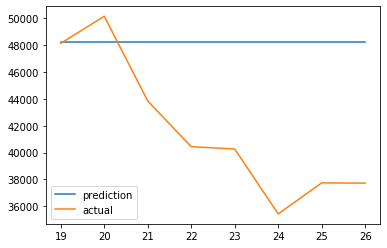

In [357]:
plt.plot(df_CY2022_test['dt_pred'],label='prediction')
plt.plot(df_CY2022_test['Total'],label='actual')
plt.legend()
plt.show()

No good :(

In [358]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(Y_UK2022_train, y=Y_CY2022_train)
gbr_pred = gbr.predict(Y_UK2022_test)
df_CY2022_test['gbr_pred'] = gbr_pred
df_CY2022_test.head()

c:\Users\roryj\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\roryj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
Traceback (most recent call last):
  File "<ipython-input-1-e55968c1e178>", line 247, in _repr_dw_
    return self._gen_json()
  File "<ipython-input-1-e55968c1e178>", line 254, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, ref=self.id, conversionMethod=tmp_vars[se

CY2022,level_0,Year,1A4ci_Agriculture/Forestry/Fishing:Stationary,1A4cii_Agriculture/Forestry/Fishing:Off-road,3D11_Agriculural_Soils_Inorganic_N_Fertilisers,3D12a_Agricultural_Soils_Manure_Applied_to_Soils,3D12b_Agricultural_Soils_Sewage_Sludge_Applied_to_Soils,3D13_Agricultural_Soils_Manure_Deposited_by_Grazing_Animals,3D14_Agriculural_Soils_Residues,3D15_Agricultural_soils_Mineralization/Immobilization,...,5C1.2a_Non-biogenic:municipal_solid_waste,5C1.2b_Non-biogenic:Clinical_waste,5C1.2b_Non-biogenic:Other_Chemical_waste,5C2.2b_Non-biogenic:Other,5C2.2b_Non-biogenic:Other_Accidental fires (vehicles),5D1_Domestic_wastewater_treatment,5D2_Industrial_wastewater_treatment,Total,dt_pred,gbr_pred
19,19.0,2015.0,63.913445,601.168270,330.958606,99.985033,13.352089,100.469736,42.942275,17.054766,...,0.0,3.902999,0.081822,0.334296,0.038168,98.276446,50.903049,48130.474830,48250.799559,48256.778841
20,20.0,2016.0,76.760896,557.119475,385.088890,98.415352,13.460369,100.277249,41.934639,17.035765,...,0.0,3.926835,0.088081,0.335546,0.039876,98.114006,46.385484,50144.660792,48250.799559,48256.778841
21,21.0,2017.0,70.905145,546.837681,404.630420,99.722773,13.886685,102.232937,42.766109,16.825184,...,0.0,3.887283,0.087869,0.328545,0.038132,98.485825,52.942834,43842.243836,48250.799559,48256.778841
22,22.0,2018.0,69.218893,581.342266,365.818406,101.220348,14.536093,97.873812,43.399579,16.519154,...,0.0,3.848250,0.096131,0.320674,0.038008,98.789643,53.454117,40440.467223,48250.799559,48256.778841
23,23.0,2019.0,74.798231,539.014987,368.928589,100.583876,14.604052,100.508990,45.802005,16.063158,...,0.0,4.012693,0.087550,0.305096,0.035247,98.504108,50.815674,40267.604439,48250.799559,48256.778841


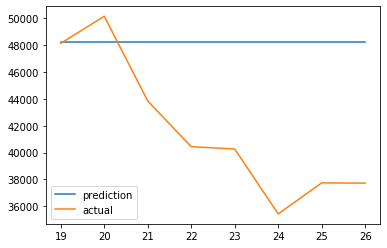

In [359]:
plt.plot(df_CY2022_test['gbr_pred'],label='prediction')
plt.plot(df_CY2022_test['Total'],label='actual')
plt.legend()
plt.show()